In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

from glob import glob
import torch
import torch.nn as nn
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader
import torchvision
from tqdm.autonotebook import tqdm

<ipython-input-1-55424f64c683>:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'Currently using "{device}" device.')

Currently using "cuda" device.


In [4]:
seed=56
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [5]:
import pandas as pd
from glob import glob

In [6]:
images_folder_path="/content/drive/MyDrive/project/crack_segmentation_dataset/train/images"
masks_folder_path="/content/drive/MyDrive/project/crack_segmentation_dataset/train/masks"

In [7]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset
import torchvision.transforms as T
from sklearn.model_selection import train_test_split
image_size=(224,224)
class SegmentationDataset(Dataset):
    def __init__(self, images_folder, masks_folder, image_files, mask_files, image_transform=None, mask_transform=None):
        self.images_folder = images_folder
        self.masks_folder = masks_folder
        self.image_files = image_files
        self.mask_files = mask_files
        self.image_transform = image_transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = os.path.join(self.images_folder, self.image_files[idx])
        mask_path = os.path.join(self.masks_folder, self.image_files[idx])

        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")
        mask_np = np.array(mask)

        _, mask_cv2 = cv2.threshold(mask_np, 128, 255, cv2.THRESH_BINARY)
        mask = Image.fromarray(mask_cv2)

        if self.image_transform:
            image = self.image_transform(image)

        if self.mask_transform:
            mask = self.mask_transform(mask)
        mask[mask > 0.5] = 1
        mask[mask <= 0.5] = 0

        return image, mask

In [8]:
image_transform = T.Compose([
    T.Resize((224, 224)),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

mask_transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor()
])

In [9]:
image_files = sorted(os.listdir(images_folder_path))
mask_files = sorted(os.listdir(masks_folder_path))


In [10]:
image_files=image_files[:6000]
mask_files=mask_files[:6000]

In [11]:
image_train, image_test, mask_train, mask_test = train_test_split(image_files, mask_files, test_size=0.2, random_state=42)

In [12]:
train_dataset = SegmentationDataset(images_folder_path, masks_folder_path, image_train, mask_train,image_transform=image_transform,mask_transform=mask_transform)
test_dataset = SegmentationDataset(images_folder_path, masks_folder_path, image_test, mask_test,image_transform=image_transform,mask_transform=mask_transform)

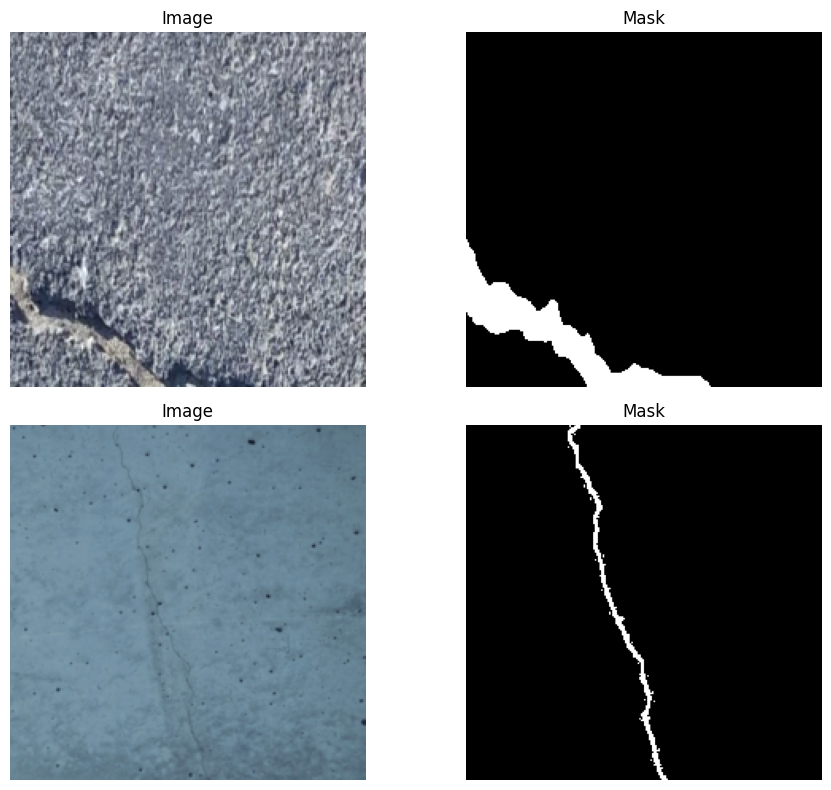

In [13]:
import matplotlib.pyplot as plt

num_images_to_display = 2
fig, axes = plt.subplots(num_images_to_display, 2, figsize=(10, 8))

for i in range(num_images_to_display):
    random_index = torch.randint(len(train_dataset), size=(1,)).item()
    image, mask = train_dataset[random_index]
    axes[i, 0].imshow((image.permute(1, 2, 0) * 0.229 + 0.485).clamp(0, 1))
    axes[i, 0].set_title('Image')
    axes[i, 0].axis('off')
    axes[i, 1].imshow(mask.squeeze(), cmap='gray')
    axes[i, 1].set_title('Mask')
    axes[i, 1].axis('off')
plt.tight_layout()
plt.show()

In [14]:
from torch.utils.data import DataLoader

batch_size = 8  #
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [15]:
for images, masks in train_loader:
    print("Training batch - Images shape:", images.shape, "Masks shape:", masks.shape)
    unique_values = torch.unique(masks)
    print("Unique values in mask (train):", unique_values)
    break

for images, masks in test_loader:
    print("Validation batch - Images shape:", images.shape, "Masks shape:", masks.shape)
    unique_values = torch.unique(masks)
    print("Unique values in mask (val):", unique_values)
    break

Training batch - Images shape: torch.Size([8, 3, 224, 224]) Masks shape: torch.Size([8, 1, 224, 224])
Unique values in mask (train): tensor([0., 1.])
Validation batch - Images shape: torch.Size([8, 3, 224, 224]) Masks shape: torch.Size([8, 1, 224, 224])
Unique values in mask (val): tensor([0., 1.])


In [16]:
import matplotlib.pyplot as plt
import numpy as np
def display_images_and_masks(loader):
    for batch_idx, (images, masks) in enumerate(loader):
        for i in range(len(images)):

            fig, axes = plt.subplots(1, 2, figsize=(8, 4))
            axes[0].imshow((images[i].permute(1, 2, 0) * 0.229 + 0.485).clamp(0, 1))
            axes[0].set_title('Image')
            axes[0].axis('off')

            axes[1].imshow(masks[i].squeeze(), cmap='gray')
            axes[1].set_title('Mask')
            axes[1].axis('off')

            plt.tight_layout()
            plt.show()
        break

display_images_and_masks(train_loader)


Output hidden; open in https://colab.research.google.com to view.

In [17]:
!pip install segmentation-models-pytorch
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 7.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  U

In [18]:
import os
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from segmentation_models_pytorch import Unet
import segmentation_models_pytorch as smp

In [19]:
model = smp.Unet( encoder_name="vgg16",
    encoder_weights="imagenet", in_channels=3, classes=1)
#loss_function = torch.nn.CrossEntropyLoss()
from torch.nn.functional import binary_cross_entropy_with_logits

def dice_loss(logits, targets):
    smooth = 1e-5
    logits = torch.sigmoid(logits)
    intersection = (logits * targets).sum()
    union = logits.sum() + targets.sum() + smooth
    dice = (2 * intersection + smooth) / union
    return 1 - dice

loss_function = dice_loss

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:08<00:00, 62.2MB/s]


Unet(
  (encoder): VGGEncoder(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      

In [20]:
import segmentation_models_pytorch as smp
import torch
import torch.nn.functional as F


num_epochs = 20

def iou_score(pred, target):
    smooth = 1e-5
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection + smooth
    iou = (intersection + smooth) / union
    return iou

def precision(pred, target):
    smooth = 1e-5
    true_positive = (pred * target).sum()
    predicted_positive = pred.sum() + smooth
    precision = true_positive / predicted_positive
    return precision

def recall(pred, target):
    smooth = 1e-5
    true_positive = (pred * target).sum()
    actual_positive = target.sum() + smooth
    recall = true_positive / actual_positive
    return recall

def f1(pred, target):
    prec = precision(pred, target)
    rec = recall(pred, target)
    f1 = 2 * (prec * rec) / (prec + rec + 1e-5)
    return f1

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_losses = []
train_ious = []
train_dices = []
train_precisions = []
train_recalls = []
train_f1s = []
val_losses = []
val_ious = []
val_dices = []
val_precisions = []
val_recalls = []
val_f1s = []

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    epoch_iou = 0.0
    epoch_dice = 0.0
    epoch_precision = 0.0
    epoch_recall = 0.0
    epoch_f1 = 0.0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = dice_loss(output, target)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        # Calculate metrics for each batch and accumulate
        pred = torch.sigmoid(output) > 0.5
        iou = iou_score(pred, target)
        dice = 1 - loss.item()  # Dice coefficient is 1 - dice_loss
        precision_score = precision(pred, target)
        recall_score = recall(pred, target)
        f1_score = f1(pred, target)

        epoch_iou += iou.item()
        epoch_dice += dice
        epoch_precision += precision_score
        epoch_recall += recall_score
        epoch_f1 += f1_score

    # Calculate and store training metrics
    train_loss = epoch_loss / len(train_loader)
    train_losses.append(train_loss)
    avg_train_iou = epoch_iou / len(train_loader)
    train_ious.append(avg_train_iou)
    avg_train_dice = epoch_dice / len(train_loader)
    train_dices.append(avg_train_dice)
    avg_train_precision = epoch_precision / len(train_loader)
    train_precisions.append(avg_train_precision)
    avg_train_recall = epoch_recall / len(train_loader)
    train_recalls.append(avg_train_recall)
    avg_train_f1 = epoch_f1 / len(train_loader)
    train_f1s.append(avg_train_f1)

    # Evaluation loop
    model.eval()
    iou_total = 0.0
    dice_total = 0.0
    precision_total = 0.0
    recall_total = 0.0
    f1_total = 0.0
    val_loss = 0.0
    num_samples = 0

    with torch.no_grad():
        for data, target in test_loader:  # Assuming you have validation data
            data, target = data.to(device), target.to(device)

            output = model(data)
            pred = torch.sigmoid(output) > 0.5

            iou = iou_score(pred, target)
            dice = 1 - dice_loss(output, target)
            precision_score = precision(pred, target)
            recall_score = recall(pred, target)
            f1_score = f1(pred, target)

            iou_total += iou.item()
            dice_total += dice
            precision_total += precision_score
            recall_total += recall_score
            f1_total += f1_score

            loss = dice_loss(output, target)
            val_loss += loss.item()

            num_samples += 1

    val_iou = iou_total / num_samples
    val_dice = dice_total / num_samples
    val_precision = precision_total / num_samples
    val_recall = recall_total / num_samples
    val_f1 = f1_total / num_samples
    val_losses.append(val_loss / len(test_loader))
    val_ious.append(val_iou)
    val_dices.append(val_dice)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    val_f1s.append(val_f1)

    # Print the results for this epoch
    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Train Loss: {train_loss:.4f}, Train IOU: {avg_train_iou:.4f}, Train Dice: {avg_train_dice:.4f}, "
          f"Train Precision: {avg_train_precision:.4f}, Train Recall: {avg_train_recall:.4f}, Train F1: {avg_train_f1:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val IOU: {val_iou:.4f}, Val Dice: {val_dice:.4f}, "
          f"Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}, Val F1: {val_f1:.4f}")


Epoch [1/20] - Train Loss: 0.4193, Train IOU: 0.4405, Train Dice: 0.5807, Train Precision: 0.5929, Train Recall: 0.6618, Train F1: 0.6003, Val Loss: 48.4181, Val IOU: 0.5190, Val Dice: 0.6772, Val Precision: 0.7174, Val Recall: 0.6553, Val F1: 0.6791
Epoch [2/20] - Train Loss: 0.3230, Train IOU: 0.5194, Train Dice: 0.6770, Train Precision: 0.6805, Train Recall: 0.6940, Train F1: 0.6785, Val Loss: 49.3259, Val IOU: 0.5107, Val Dice: 0.6712, Val Precision: 0.7122, Val Recall: 0.6459, Val F1: 0.6725
Epoch [3/20] - Train Loss: 0.2965, Train IOU: 0.5485, Train Dice: 0.7035, Train Precision: 0.7064, Train Recall: 0.7171, Train F1: 0.7044, Val Loss: 43.2883, Val IOU: 0.5572, Val Dice: 0.7114, Val Precision: 0.6769, Val Recall: 0.7599, Val F1: 0.7122
Epoch [4/20] - Train Loss: 0.2864, Train IOU: 0.5596, Train Dice: 0.7136, Train Precision: 0.7168, Train Recall: 0.7235, Train F1: 0.7142, Val Loss: 41.8078, Val IOU: 0.5686, Val Dice: 0.7213, Val Precision: 0.6857, Val Recall: 0.7709, Val F1: 0.7

In [21]:
val_dic = [item.item() for item in val_dices]

In [22]:
train_precision=[item.item() for item in train_precisions]
val_precision=[item.item() for item in val_precisions]
train_recall=[item.item() for item in train_recalls]
val_recall=[item.item() for item in val_recalls]
train_f1=[item.item() for item in train_f1s]
val_f1=[item.item() for item in val_f1s]

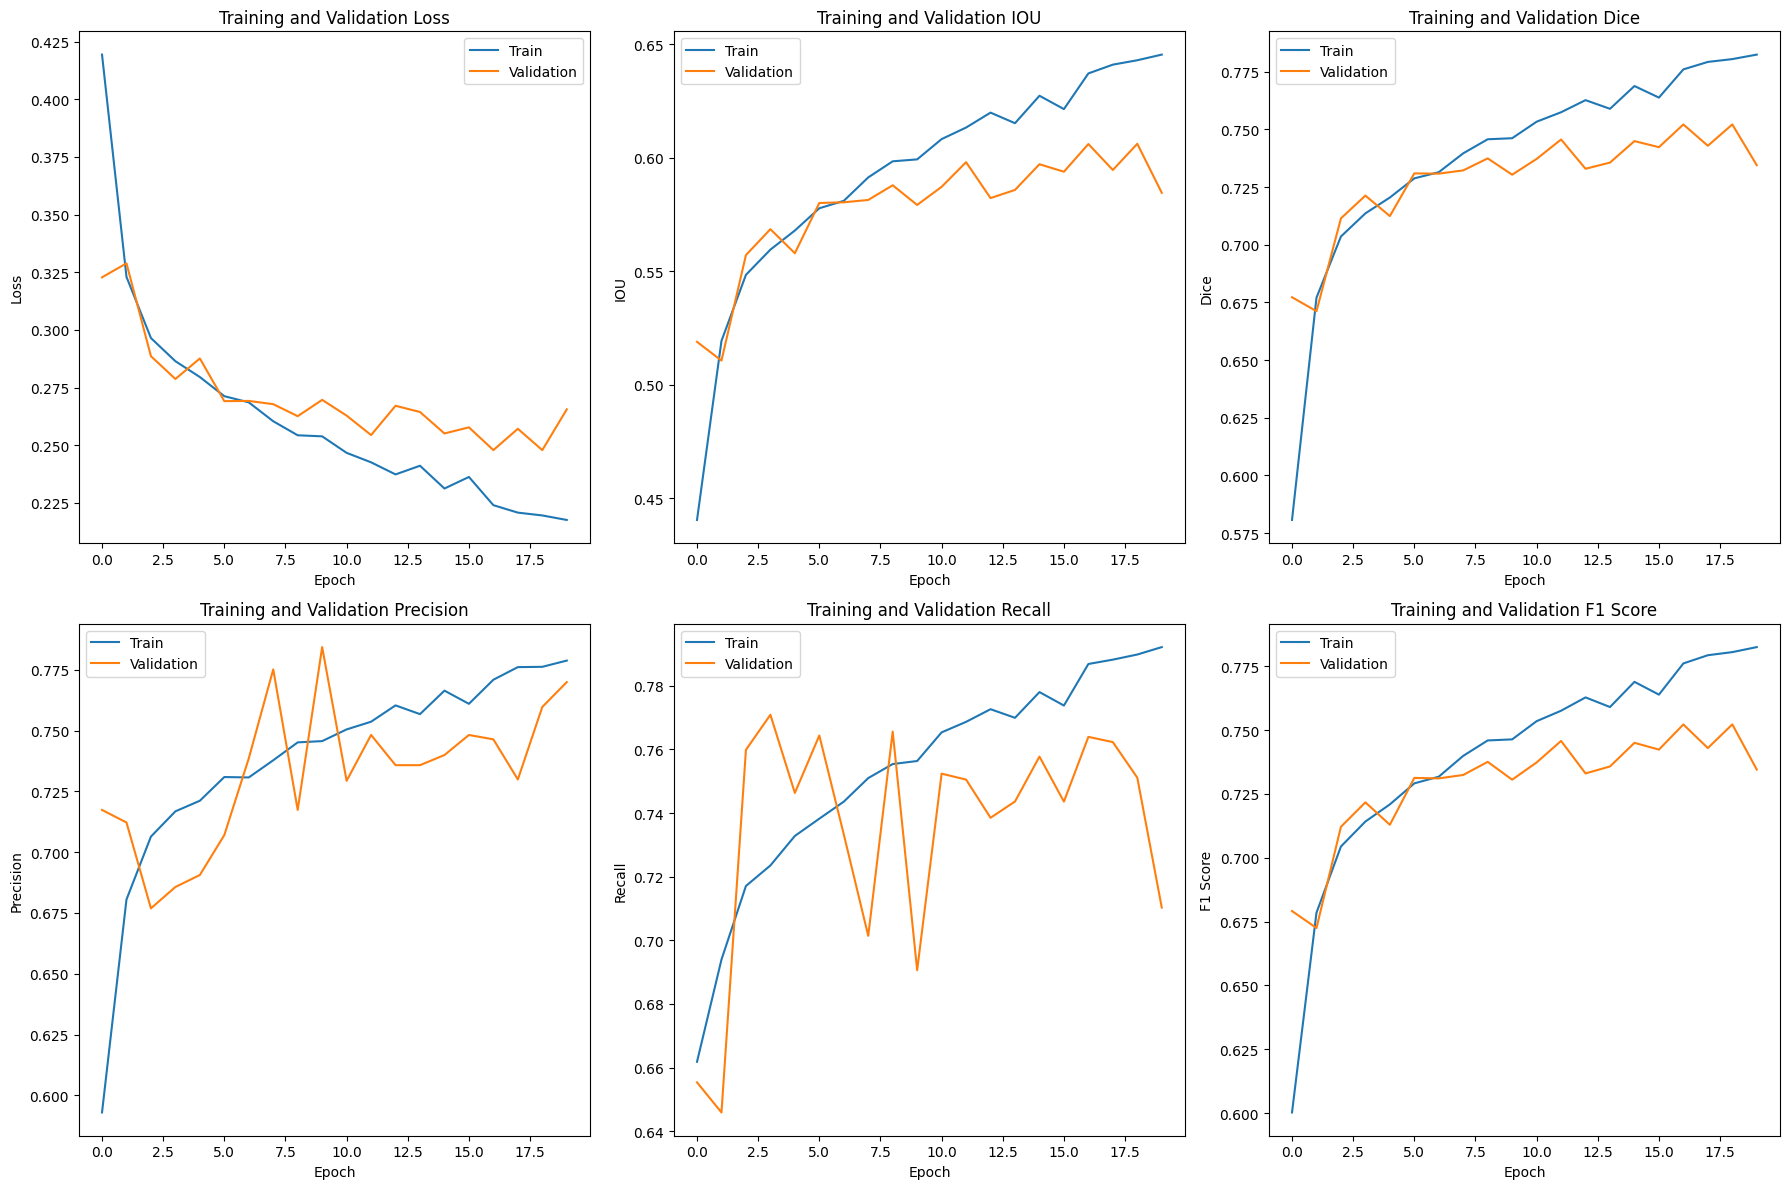

In [23]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation IOU
plt.subplot(2, 3, 2)
plt.plot(train_ious, label='Train')
plt.plot(val_ious, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('IOU')
plt.title('Training and Validation IOU')
plt.legend()

# Plot training and validation Dice
plt.subplot(2, 3, 3)
plt.plot(train_dices, label='Train')
plt.plot(val_dic, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Dice')
plt.title('Training and Validation Dice')
plt.legend()

# Plot training and validation Precision
plt.subplot(2, 3, 4)
plt.plot(train_precision, label='Train')
plt.plot(val_precision, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Training and Validation Precision')
plt.legend()

# Plot training and validation Recall
plt.subplot(2, 3, 5)
plt.plot(train_recall, label='Train')
plt.plot(val_recall, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Training and Validation Recall')
plt.legend()

# Plot training and validation F1 Score
plt.subplot(2, 3, 6)
plt.plot(train_f1, label='Train')
plt.plot(val_f1, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('Training and Validation F1 Score')
plt.legend()

plt.tight_layout()
plt.show()


In [24]:
torch.save(model.state_dict(), '/content/drive/MyDrive/project/vgg16.pth')

In [25]:
model.load_state_dict(torch.load('/content/drive/MyDrive/project/vgg16.pth'))
model.eval()

Unet(
  (encoder): VGGEncoder(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      

In [26]:
for batch_idx, (images, masks) in enumerate(test_loader):
    images, masks = images.to(device), masks.to(device)
    outputs = model(images)
    predicted_masks = torch.sigmoid(outputs) > 0.5
    for i in range(len(images)):

        fig, axes = plt.subplots(1, 3, figsize=(12, 6))
        axes[0].imshow((images[i].cpu().permute(1, 2, 0) * 0.229 + 0.485).clamp(0, 1))
        axes[0].set_title('Image')
        axes[0].axis('off')

        axes[1].imshow(predicted_masks[i].cpu().squeeze(), cmap='gray')
        axes[1].set_title('predicted_mask')
        axes[1].axis('off')

        axes[2].imshow(masks[i].cpu().squeeze(), cmap='gray')
        axes[2].set_title('Mask')
        axes[2].axis('off')

        plt.tight_layout()
        plt.show()
    break

Output hidden; open in https://colab.research.google.com to view.